# Collaborative Filtering Recommender - Steam Games
In this personal project, I build a user-user collaborative filtering recommender algorithm for video games on steam. I saw the data on kaggle and thought it was super cool and wanted to see what I could come up with!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

## Data Pre-Processing
The data [(found here)](https://www.kaggle.com/datasets/tamber/steam-video-games/data) comes from Kaggle and contains about 200k Steam (a platform for downloading and playing games) user interactions. These interactions record a user purchasing a game, playing it, and the number of hours they played. Below, I import the data and get a first look at its structure.

In [2]:
#Load data

# Replace 'your_file_path.csv' with the path to your CSV file
file_path = 'steam-200k.csv'

# Import the CSV file
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(df.head())

   151603712  The Elder Scrolls V Skyrim  purchase    1.0  0
0  151603712  The Elder Scrolls V Skyrim      play  273.0  0
1  151603712                   Fallout 4  purchase    1.0  0
2  151603712                   Fallout 4      play   87.0  0
3  151603712                       Spore  purchase    1.0  0
4  151603712                       Spore      play   14.9  0


In [3]:
df.columns = ['user_id', 'game_name', 'purchase_type', 'hours_played','na']

In [4]:
print(df.head())

     user_id                   game_name purchase_type  hours_played  na
0  151603712  The Elder Scrolls V Skyrim          play         273.0   0
1  151603712                   Fallout 4      purchase           1.0   0
2  151603712                   Fallout 4          play          87.0   0
3  151603712                       Spore      purchase           1.0   0
4  151603712                       Spore          play          14.9   0


In [5]:
# Assuming 'df' is your DataFrame and it has a column 'game_name'

# Print 200 unique game names from 'game_name' column
unique_game_names = df['game_name'].unique()[:10]
print(unique_game_names)


['The Elder Scrolls V Skyrim' 'Fallout 4' 'Spore' 'Fallout New Vegas'
 'Left 4 Dead 2' 'HuniePop' 'Path of Exile' 'Poly Bridge' 'Left 4 Dead'
 'Team Fortress 2']


Unintuitively, you can see the data is segregated on purchase type and a user/game pair often have two entries. While potentially helpful in other contexts, I don't see how that would help us so I just aggregated those entries together as follows:

In [6]:
aggregated_data = df.groupby(['user_id', 'game_name']).agg({
    'purchase_type': 'max',  # Assuming 'purchase' > 'play' if sorted, otherwise adjust logic
    'hours_played': 'sum'  # Sum hours played for both purchase and play records
}).reset_index()

In [7]:
aggregated_data

,user_id,game_name,purchase_type,hours_played
0,5250,Alien Swarm,purchase,5.9
1,5250,Cities Skylines,purchase,145.0
2,5250,Counter-Strike,purchase,1.0
3,5250,Counter-Strike Source,purchase,1.0
4,5250,Day of Defeat,purchase,1.0
...,...,...,...,...
128799,309626088,Age of Empires II HD Edition,purchase,7.7
128800,309812026,Counter-Strike Nexon Zombies,purchase,1.0
128801,309812026,Robocraft,purchase,1.0
128802,309824202,Dota 2,purchase,1.7


This following cell is not important until later. I wanted to train the data with myself as a user, so I appended some entries for myself so that when the recommendation system was built I could recommend to myself as well! I filled out the columns with plausible data representing some games I like.

In [8]:
my_entries = {
    'user_id': [999999999, 999999999, 999999999, 999999999, 999999999],
    'game_name': ['Spore', 'Rocket League','Terraria','LEGO Harry Potter Years 5-7','The Sims(TM) 3'],
    'purchase_type':['purchase','purchase','purchase','purchase','purchase'],
    'hours_played': [20, 8, 10, 3, 10]
}

aggregated_data = aggregated_data.append(pd.DataFrame(my_entries), ignore_index=True)

/var/folders/ws/291c9w6d10j8wy4wnkjqfcy00000gn/T/ipykernel_1985/809475425.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  aggregated_data = aggregated_data.append(pd.DataFrame(my_entries), ignore_index=True)


In [9]:
aggregated_data

,user_id,game_name,purchase_type,hours_played
0,5250,Alien Swarm,purchase,5.9
1,5250,Cities Skylines,purchase,145.0
2,5250,Counter-Strike,purchase,1.0
3,5250,Counter-Strike Source,purchase,1.0
4,5250,Day of Defeat,purchase,1.0
...,...,...,...,...
128804,999999999,Spore,purchase,20.0
128805,999999999,Rocket League,purchase,8.0
128806,999999999,Terraria,purchase,10.0
128807,999999999,LEGO Harry Potter Years 5-7,purchase,3.0


### Exploring the "Hours Played" Feature

To get a recommendation algorithm that can recommend games one might like, I think the most relevant feature from our data is hours played. For this project, I am not trying to build a system that optimizes clicks on the game or is aimed at getting someone to buy a new game. Rather, I just want to recommend what games a person might enjoy and spend more time playing. So this feature turns out to be perfect. 

Were I trying to build a system that optimized buying or clicking on a game, this recommendation algorithm could serve as a useful approximation but would benefit from some adjustments. I would definitely want to introduce whether or not the game was bought into the feature more prominently than just linearly represented game played (i.e. +10 hours added to the feature if game bought rather than played). That's all speculative though, and I'm happy to build a model where hours_played is the primary feature to probe at a more fun question of what games people might like to play more based on games they've already played.

Below I look at the data more closely to see what kind of scaling needs to be done.

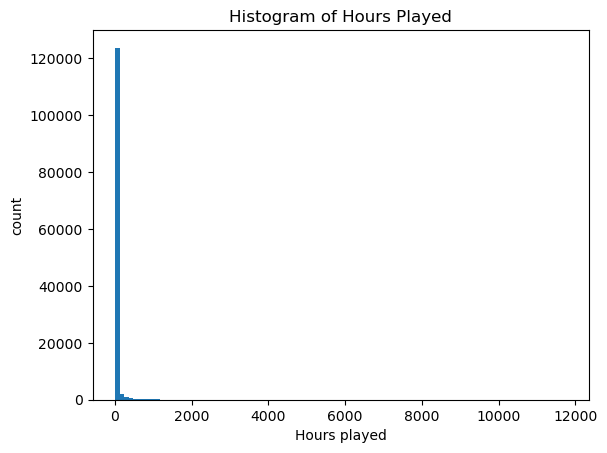

In [10]:
plt.hist(aggregated_data['hours_played'],bins=100);
plt.title("Histogram of Hours Played");
plt.ylabel("count");
plt.xlabel("Hours played");

Yikes

Looks like some high outliers are in the data.

In [11]:
max(aggregated_data['hours_played'])

11755.0

Yeah a max value around 11755 with most data around 5-30 seems cause for some normalization. MinMax likely wouldn't be the best solution here given that I want to minimize the effect of outliers, too.

In [12]:
#normalize data
scaler = MinMaxScaler()
minMaxScalerCheck = scaler.fit_transform(np.array(aggregated_data['hours_played']).reshape(-1, 1))

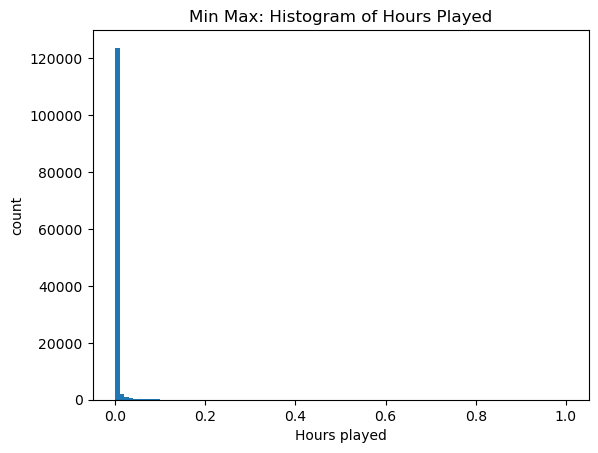

In [13]:
plt.hist(minMaxScalerCheck,bins=100);
plt.title("Min Max: Histogram of Hours Played");
plt.ylabel("count");
plt.xlabel("Hours played");

Ew

In [14]:
scaler = QuantileTransformer(output_distribution='uniform')
quantileTransformerCheck = scaler.fit_transform(np.array(aggregated_data['hours_played']).reshape(-1, 1))

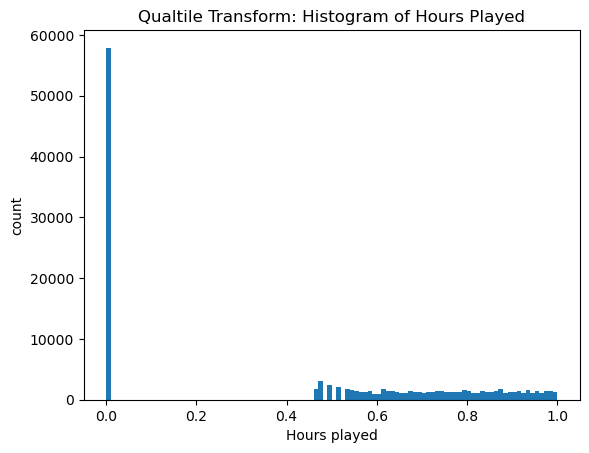

In [15]:
plt.hist(quantileTransformerCheck,bins=100);
plt.title("Qualtile Transform: Histogram of Hours Played");
plt.ylabel("count");
plt.xlabel("Hours played");

This looks clearly bad. The fact that so much data stands at 1 hour of play given how the data is recorded. This is a bad solution because it moves just playing a little over an hour so far from the data where hours_played = 1, that this would make our model worse.

In [16]:
scaler = RobustScaler()
robustScalerCheck = scaler.fit_transform(np.array(aggregated_data['hours_played']).reshape(-1, 1))

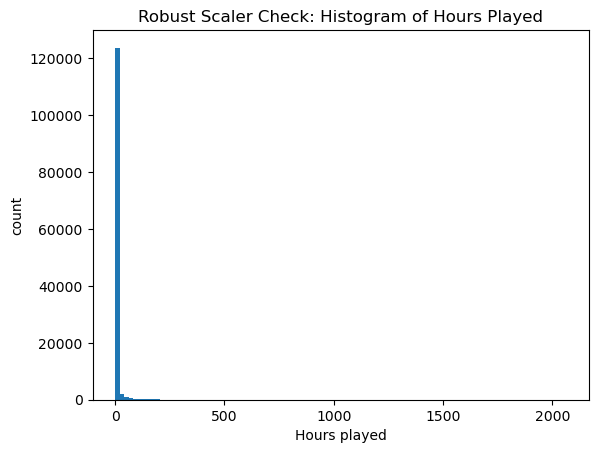

In [17]:
plt.hist(robustScalerCheck,bins=100);
plt.title("Robust Scaler Check: Histogram of Hours Played");
plt.ylabel("count");
plt.xlabel("Hours played");

Well, that at least reduced most of the data to more reasonable values but didn't make it look more gaussian (as this function can't change the shape of the histogram other than scaling and recentering).

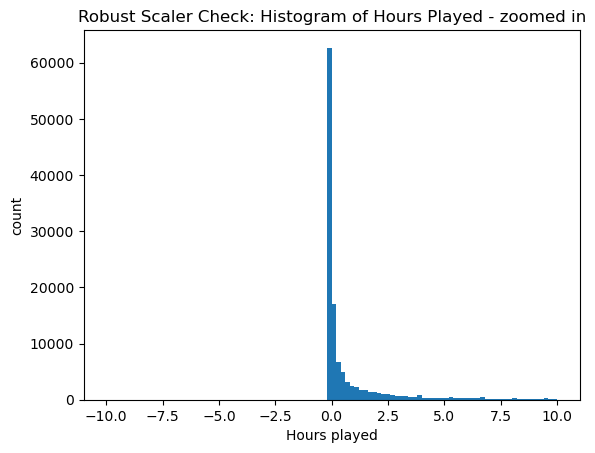

In [18]:
plt.hist(robustScalerCheck,bins=100,range=(-10,10));
plt.title("Robust Scaler Check: Histogram of Hours Played - zoomed in");
plt.ylabel("count");
plt.xlabel("Hours played");

In [19]:
scaler = PowerTransformer()
powerTransformCheck = scaler.fit_transform(np.array(aggregated_data['hours_played']).reshape(-1, 1))

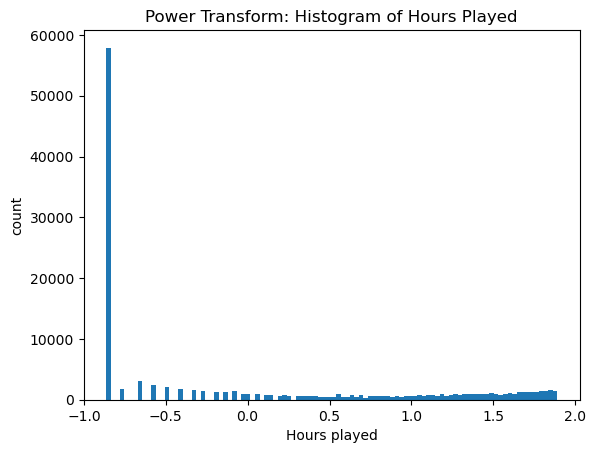

In [20]:
plt.hist(powerTransformCheck,bins=100);
plt.title("Power Transform: Histogram of Hours Played");
plt.ylabel("count");
plt.xlabel("Hours played");

I'm not content with this and am now after trying these simple solutions convinced that forcing away the outliers messes with the lower levels of hours played more than it helps them. The problem of these higher outliers still exists, and should be noted. We will make sure that the algorithm we make is robust to handle users whose game played time is astronomically higher than others. More on that as the model is built.

For now, I will just use robust scaler so the scaling is not controlled by outliers, but still gets the numbers to more reasonable scales to work with. I choose with_centering false because, in principle, I would like any amount of hours played to be considered "positive".

In [21]:
scaler = RobustScaler(with_centering=False, with_scaling=True)
robustScalered = scaler.fit_transform(np.array(aggregated_data['hours_played']).reshape(-1, 1))
aggregated_data['hours_played'] = robustScalered

In [22]:
min(aggregated_data['hours_played'])

0.17543859649122806

In [23]:
aggregated_data

,user_id,game_name,purchase_type,hours_played
0,5250,Alien Swarm,purchase,1.035088
1,5250,Cities Skylines,purchase,25.438596
2,5250,Counter-Strike,purchase,0.175439
3,5250,Counter-Strike Source,purchase,0.175439
4,5250,Day of Defeat,purchase,0.175439
...,...,...,...,...
128804,999999999,Spore,purchase,3.508772
128805,999999999,Rocket League,purchase,1.403509
128806,999999999,Terraria,purchase,1.754386
128807,999999999,LEGO Harry Potter Years 5-7,purchase,0.526316


## Building Item & User Matrices

In [24]:
# Pivot the data to get a user-item matrix
user_item_matrix = aggregated_data.pivot_table(index='user_id', columns='game_name', values='hours_played', fill_value=0)

I use cosine similarity as the metric to determine similarity for a few reasons. For one, I think the magnitude you've played all the games are not that significant (i.e. I would consider John, who played 1 hour of Game A and 3 hours of Game B to be similar to Jakob, who played 10 hours of Game A and 30 hours of Game B). It, also, tends to group together users who both have non-zero hours_played for the same games, and is known for handling sparse data well!

In [25]:
# Assuming user_item_matrix now contains 'hours_played' values
user_similarity_matrix = cosine_similarity(user_item_matrix)
user_similarity_matrix = pd.DataFrame(user_similarity_matrix, index=user_item_matrix.index, columns=user_item_matrix.index)

In [26]:
user_similarity_matrix

user_id,5250,76767,86540,103360,144736,181212,229911,298950,299153,381543,...,309265377,309375103,309404240,309434439,309554670,309626088,309812026,309824202,309903146,999999999
user_id,,,,,,,,,,,,,,,,,,,,,
5250,1.000000,0.007580,0.004095,0.015917,0.017786,0.020078,0.002250,0.022816,0.020178,0.013842,...,0.0,0.0,0.002437,0.00755,0.0,0.000000,0.0,0.00755,0.00755,0.0
76767,0.007580,1.000000,0.005717,0.221230,0.268039,0.444942,0.342244,0.005297,0.199965,0.550474,...,0.0,0.0,0.000000,0.00000,0.0,0.026361,0.0,0.00000,0.00000,0.0
86540,0.004095,0.005717,1.000000,0.018544,0.020722,0.017791,0.002146,0.106874,0.017632,0.016126,...,0.0,0.0,0.000000,0.00000,0.0,0.012461,0.0,0.00000,0.00000,0.0
103360,0.015917,0.221230,0.018544,1.000000,0.893950,0.696456,0.333303,0.002217,0.845154,0.822192,...,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.00000,0.00000,0.0
144736,0.017786,0.268039,0.020722,0.893950,1.000000,0.790599,0.097327,0.002491,0.755526,0.795725,...,0.0,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.00000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309626088,0.000000,0.026361,0.012461,0.000000,0.000000,0.000000,0.000000,0.001815,0.000000,0.000000,...,0.0,0.0,0.000000,0.00000,0.0,1.000000,0.0,0.00000,0.00000,0.0
309812026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.00000,0.0,0.000000,1.0,0.00000,0.00000,0.0
309824202,0.007550,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001237,0.000000,0.000000,...,0.0,0.0,0.000000,1.00000,0.0,0.000000,0.0,1.00000,1.00000,0.0


In [27]:
print("Hours Played Distribution")
print("Min: "+ str(aggregated_data["hours_played"].quantile(0)))
print("25th percentile: "+ str(aggregated_data["hours_played"].quantile(0.25)))
print("50th percentile: "+ str(aggregated_data["hours_played"].quantile(0.50)))
print("75th percentile: "+ str(aggregated_data["hours_played"].quantile(0.75)))
print("Max: "+ str(aggregated_data["hours_played"].quantile(1)))

reasonable_max = aggregated_data["hours_played"].quantile(0.75)

Hours Played Distribution
Min: 0.17543859649122806
25th percentile: 0.17543859649122806
50th percentile: 0.22807017543859648
75th percentile: 1.1754385964912282
Max: 2062.280701754386


Noting how the extreme, high outliers have the potential to completely overshadow any other entries if used to calculate similarity, I will cap the effect of a game played at the 75th percentile, if game_played reaches that value for that game/user pair.

### Some Justification for the Choices I Made in my Algorithm
In the recommendation algorithm below, I select the 10 closest users to provide insight to each user. This is computationally very quick and provides more fun recommendations (in my experience with playing around with this number) than using, say, the closest 500 users. It sorts through each game and adds when a game is played by one of these similar users. Most recommendation algorithms will then 'normalize' the feature by the user giving it (i.e. dividing by a user's average rating) to get more reliable results. In this instance, I think this is less helpful, because I actually want to give a user who plays the game more than another similar user more sway (although I do cap it at a certain level so players who play a ton are not biasing the results). The games are then sorted by highest score and the closest 5 are recommended.

In [39]:
def recommend_games(user_id, user_similarity_matrix, user_item_matrix, top_n=5, closest_users=10):
    # Get similarity scores for the target user, excluding themselves
    user_similarities = user_similarity_matrix.loc[user_id].drop(user_id)
    
    # Find the closest users based on similarity scores
    closest_users_scores = user_similarities.nlargest(closest_users)
    
    # Identify games the target user has already played
    played_games = user_item_matrix.loc[user_id]
    played_games = played_games[played_games > 0].index
    
    recommendations = {}
    
    # Iterate through the closest similar users and their similarity scores
    for other_user, similarity_score in closest_users_scores.items():
        # Get the hours played for games by the similar user
        other_user_games = user_item_matrix.loc[other_user]
        
        # Iterate through games played by the similar user
        for game, hours_played in other_user_games.items():
            # Exclude games played by the target user
            if game not in played_games and hours_played > 0:
                if game not in recommendations:
                    recommendations[game] = 0
                # Accumulate weighted hours played * similarity_score as the score
                recommendations[game] += max(hours_played,reasonable_max) * similarity_score
    
    # Sort the games based on the accumulated scores
    recommended_games = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    # Return the top N recommended game names
    return [game for game, _ in recommended_games][:top_n]

## Analyze Results

Here I would just like to see what it recommends for me to get a good first look into how this recommender is doing.

In [40]:
recommend_games(999999999, user_similarity_matrix, user_item_matrix,top_n=10)

["Sid Meier's Civilization V",
 'Team Fortress 2',
 "Sid Meier's Civilization Beyond Earth",
 'The Elder Scrolls V Skyrim',
 'Unturned',
 "Garry's Mod",
 'Game Dev Tycoon',
 'XCOM Enemy Unknown',
 'South Park The Stick of Truth',
 'Kerbal Space Program']

I'm actually really pleased. I intentionally picked games that are friendlier, more creative, and unique, and believe I got good recommenders that remind me of the spirit of the games I chose for my entries. The top game recommended to me: "Sid Meier's Civilization V" has been recommended to me a handful of times by multiple friends, completely independently of this process, so that's a good sign that we have a good recommender! Additionally, games like Team Fortress, Unturned, Garry's Mod, Game Dev Tycoon, South Park, and Kerbel Space Program all fit very obviously into the theme of games I picked- less serious, quirky graphics and gameplay, and emphasis on creative fun (like sims, terraria, lego harry potter, rocket league, and spore, the games I input for myself). My friend even told me "Oh Dominic you would love Kerbal Space Program," after I told him my recommender recommended it to me.

### What Now?

Not shown, I manually selected some random users and saw what games were recommended and the games that user liked, and all of the recommendations looked good to my informal visual inspection. For my purposes, this algorithm is great! It recommended for me and for some friends interesting games that seem well-suited for us. Were this algorithm to go into production on a site like Steam, some fine tuning could definitely be helpful. Here are some parts of the algorithm I'd consider tweaking:

 * closest_users: In my algorithm, I only take the ten closest users and use them to generate the recommendation. This makes the computation much quicker. I initially suspected that increasing this variable as much as possible would improve the reliability of the recommendations (as bigger sample sizes tend to help), which is likely true. But I found that the recommendations got a lot less niche and generally felt less specialized to the user at hand and more broader recommendations of more popular games that a lot of users like. Personally, I found that keeping this low gave me more interesting recommendations. But I would love to run this model at varying closest_user levels across different users and track metrics like clicks and downloads to see what number is most effective.
 * hours_played: I make the assumption that it would be best to not normalize each user's play time with itself (i.e. scale down the hours_played by user so each user has the same mean average time played per game). I still think my decision was right, but it could be worth comparing the performance of each. This could also help in having a more interpretable figure for implicit analysis.
 * recommendation score accumulation:  Additionally, The recommendations actually changed a lot as the number of closest users changed, this might suggest that I should have to weight the similarity score more strongly in the calculation so these different algorithms converge a little more. Like adding normalized hours_played * similarity_score^2 instead of just hours_played * similarity_score, for example.
 
For my purposes I will not conduct implicit analysis, but if I were to I think the simplest approach would be to randomly select m users and look at the recommended games and personally classify each as relevent or not and calculate precision@k and recall@k for each. Again were this to be integrated onto a high traffic, I would also build multiple models to put in and track metrics like click-rate, buy-rate, and play time of recommended games to compare the models.

## The end
I made an effective user-user collaborative filtering model for recommending games to users (with at least one game played) that I'm happy with. With an awareness of the cold start problems associated with recommender systems of this kind in implementation, I think it's a very useful model. Most importantly (for me), I liked the games it recommended me and am excited to try them!